## VAE

In [1]:
import numpy as np
import torch
from torch import optim
from torch.utils.data import DataLoader, TensorDataset

from models.ResVAE import ResVAE
from utils.load import load_from_dir
from copy import deepcopy
from matplotlib import pyplot as plt
from utils.generate import generate_shape, reconstruct_cw, reconstruct_shape
from hbs import boundary
import random

In [2]:
img_dir = "data/img/BW bird"

cw_np, loaded_datas = load_from_dir(img_dir, 500, 500, 25, read_from_file=True)
print(cw_np.shape)

Read from saved cw_dict file data/img/BW bird/cw_dict.pkl
(20, 500)


In [3]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
MAT_PATH = "data/preprocessed.theta.mat"
MODEL_SAVE_PATH = "checkpoints/ResVAE.pth"
SEED = 717

INPUT_DIM = 500  # Adjusted input dimension to match your complex data
H_DIM = 1000
Z_DIM = 2
H_LAYERS = [2,2]

NUM_EPOCHS = 20000
BATCH_SIZE = 64  # Adjusted batch size
LR_RATE = 5e-5 #smaller learning rate
KL_RATE = 1
TRUE_RATE = 1

random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

In [4]:
cw_tensor = torch.tensor(cw_np).to(dtype=torch.float64)

train_data = TensorDataset(cw_tensor)
train_loader = DataLoader(
    dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True
)

## Init model
model = ResVAE(
    input_dim=INPUT_DIM,
    hidden_dim=H_DIM,
    hidden_layers=H_LAYERS,
    latent_dim=Z_DIM,
    device=DEVICE,
)
model.to(dtype=torch.float64)
model.initial()

## Load model
# model = torch.load('VAE_theta+bias1.pth')

optimizer = optim.Adam(
    model.parameters(), lr=LR_RATE, weight_decay=1e-5, betas=(0.5, 0.999)
)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10000], gamma=0.5)

# model.to(DEVICE)

loader_size = len(train_loader)
loss_list_dict = {}
best_loss = 1e9

In [51]:
model.train()

# optimizer = optim.Adam(
#     model.parameters(), lr=1e-5, weight_decay=1e-5, betas=(0.5, 0.999)
# )
# best_loss = 1e9
# NUM_EPOCHS = 1000

for epoch in range(NUM_EPOCHS):
    for i, [input_data] in enumerate(train_loader):
        input_data = input_data.to(DEVICE, dtype=torch.float64).view(
            input_data.shape[0], INPUT_DIM
        )
        x_reconstructed, mu, logvar = model(input_data)

        # Compute loss
        # kl_rate = get_kl_rate(epoch)
        kl_rate = KL_RATE
        true_rate = TRUE_RATE
        loss_dict = model.loss(
            x_reconstructed, input_data, mu, logvar, kl_rate, true_rate
        )

        # Backprop
        optimizer.zero_grad()
        loss_dict["loss"].backward()
        optimizer.step()
        # scheduler.step()

        # Append losses to the lists
        for k, v in loss_dict.items():
            if k not in loss_list_dict:
                loss_list_dict[k] = np.zeros(loader_size)

            loss_list_dict[k][i] = v.item()

    if best_loss > loss_dict["loss"].item():
        best_loss = loss_dict["loss"].item()
        print(
            f"Best epoch {epoch}/{NUM_EPOCHS} | {', '.join([f'{k}: {v.mean():.4f}' for k, v in loss_list_dict.items()])}"
        )
        best_params = deepcopy(model.state_dict())
        # torch.save(model.state_dict(), MODEL_SAVE_PATH)

    if epoch % 100 == 0:
        print(
            f"Epoch {epoch}/{NUM_EPOCHS} | {', '.join([f'{k}: {v.mean():.4f}' for k, v in loss_list_dict.items()])}"
        )

    # if epoch % 1000 == 0:
    #     torch.save(model, "checkpoints/ResVAE.pth")

model.load_state_dict(best_params)
# torch.save(best_params, "checkpoints/ResVAE.pth")

Epoch 0/1000 | loss: 10.4037, recon_loss: 0.7055, kl_loss: 9.6633, true_loss: 0.0349


Epoch 100/1000 | loss: 54.5549, recon_loss: 32.9372, kl_loss: 19.7449, true_loss: 1.8728
Epoch 200/1000 | loss: 21.2620, recon_loss: 2.8368, kl_loss: 18.3676, true_loss: 0.0576
Epoch 300/1000 | loss: 18.2423, recon_loss: 1.1481, kl_loss: 17.0712, true_loss: 0.0230
Epoch 400/1000 | loss: 16.2615, recon_loss: 0.7652, kl_loss: 15.4544, true_loss: 0.0420
Epoch 500/1000 | loss: 15.5050, recon_loss: 0.8607, kl_loss: 14.5544, true_loss: 0.0899
Epoch 600/1000 | loss: 14.9082, recon_loss: 0.7996, kl_loss: 14.0275, true_loss: 0.0811
Epoch 700/1000 | loss: 14.3496, recon_loss: 0.6602, kl_loss: 13.6117, true_loss: 0.0776
Epoch 800/1000 | loss: 13.9660, recon_loss: 0.5998, kl_loss: 13.3190, true_loss: 0.0471
Epoch 900/1000 | loss: 14.1478, recon_loss: 0.9628, kl_loss: 13.1069, true_loss: 0.0781


<All keys matched successfully>

Generate Data

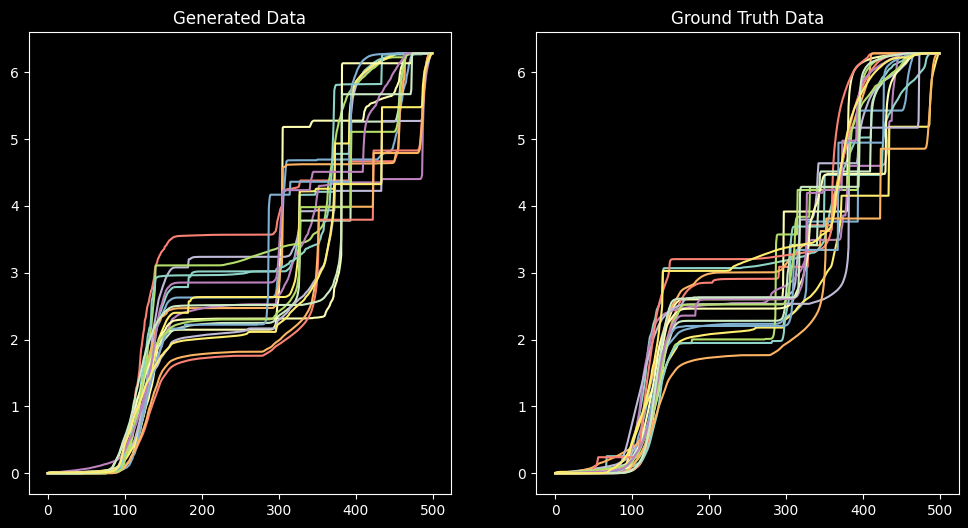

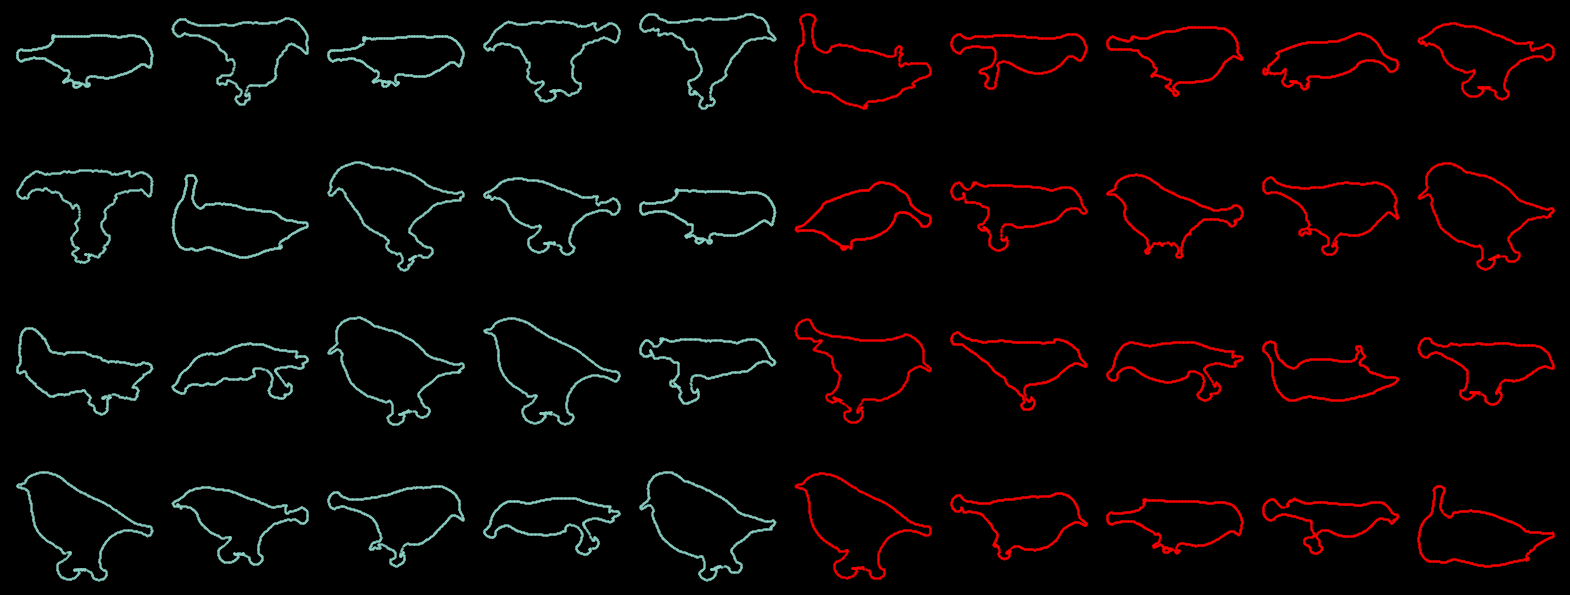

In [52]:
n = cw_tensor.shape[0]

generated_shape, generated_cw, gdata, _ = generate_shape(model, num=n, k=2)

ground_truth_cw = reconstruct_cw(model, cw_tensor)
ground_truth_shape = reconstruct_shape(ground_truth_cw)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121)
ax.title.set_text("Generated Data")
for i in range(generated_cw.shape[0]):
    ax.plot(generated_cw[i])

ax = fig.add_subplot(122)
ax.title.set_text("Ground Truth Data")
for i in range(ground_truth_cw.shape[0]):
    ax.plot(ground_truth_cw[i])

x_num = 5
y_num = int(np.floor(2 * n / x_num))
subfigure_size = 2
fig = plt.figure(figsize=(2 * x_num * subfigure_size, y_num * subfigure_size))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

# Blue for generated data
for i in range(n):
    shape = generated_shape[i]
    shape = np.stack([shape.real, shape.imag], axis=1)
    # shape = generated_shape[i]
    try:
        shape = boundary.smooth_resample(shape)
    except:
        pass
    shape = shape[:, 0] + 1j * shape[:, 1]
    k = i // x_num * 2 * x_num + i % x_num + 1
    plt.subplot(y_num, 2 * x_num, k)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.scatter(shape.real, shape.imag, s=0.3)
    plt.axis("off")

# Red for ground truth data
for i in range(n):
    # print(generated_shape[i].shape)
    shape = ground_truth_shape[i]
    shape = np.stack([shape.real, shape.imag], axis=1)
    # print(shape.shape)
    try:
        shape = boundary.smooth_resample(shape)
    except:
        pass
    shape = shape[:, 0] + 1j * shape[:, 1]
    k = i // x_num * 2 * x_num + i % x_num + 1 + x_num
    plt.subplot(y_num, 2 * x_num, k)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.scatter(shape.real, shape.imag, s=0.3, color="r")
    plt.axis("off")

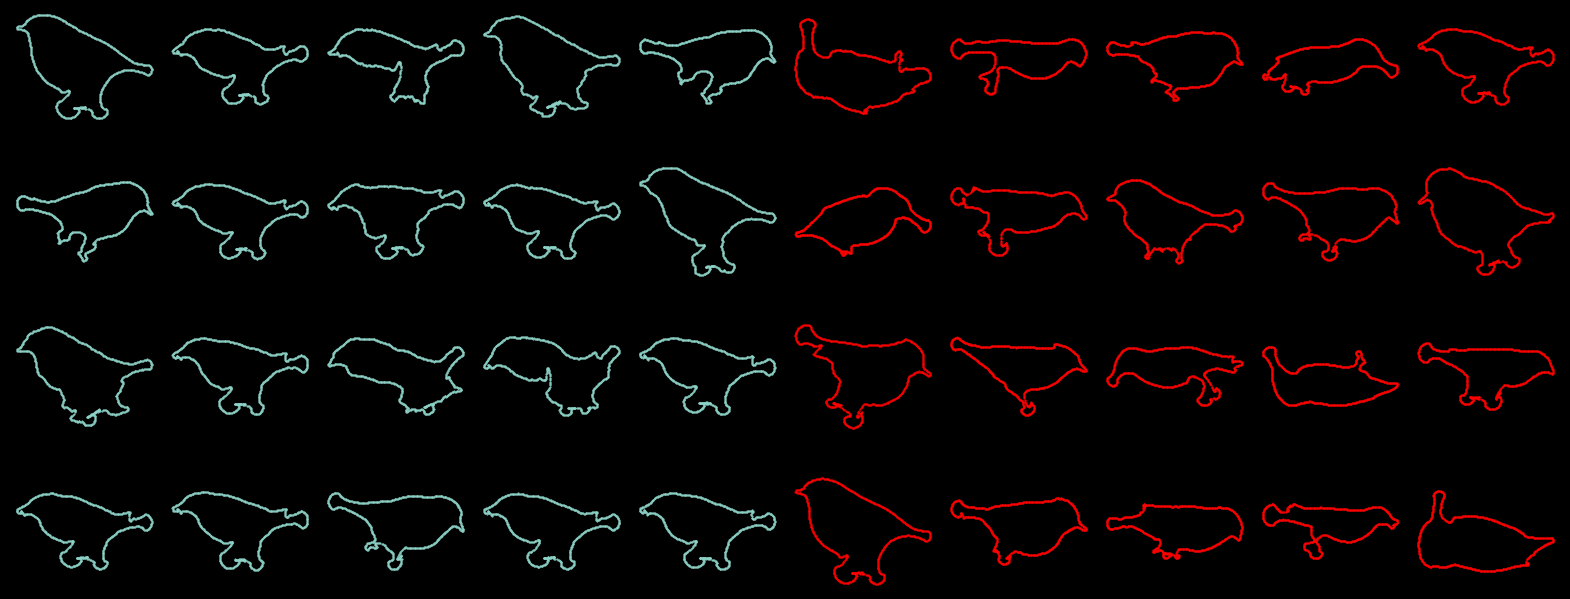

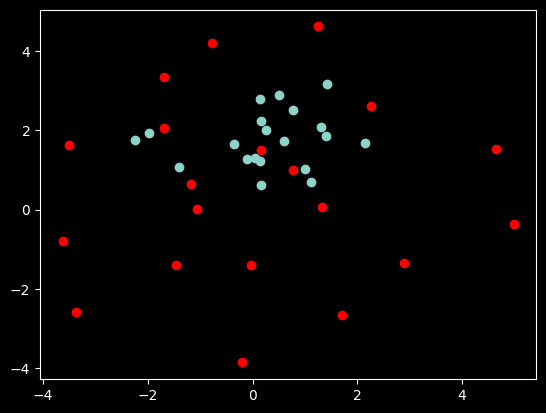

In [53]:
num = 4
var = 0.8
mu, log_var = model.encode(cw_tensor.to(DEVICE, dtype=torch.float64))
z0 = mu + log_var.exp().sqrt()
mu_vals = torch.repeat_interleave(z0[num].view(1, -1), n, dim=0)
generated_shape, generated_cw, _, z = generate_shape(
    model, num=n, mu_vals=mu_vals, k=var
)

fig = plt.figure(figsize=(2 * x_num * subfigure_size, y_num * subfigure_size))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

for i in range(n):
    shape = generated_shape[i]
    shape = np.stack([shape.real, shape.imag], axis=1)
    try:
        shape = boundary.smooth_resample(shape)
    except:
        pass
    shape = shape[:, 0] + 1j * shape[:, 1]
    k = i // x_num * 2 * x_num + i % x_num + 1
    plt.subplot(y_num, 2 * x_num, k)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.scatter(shape.real, shape.imag, s=0.3)
    plt.axis("off")

for i in range(n):
    shape = ground_truth_shape[i]
    shape = np.stack([shape.real, shape.imag], axis=1)
    try:
        shape = boundary.smooth_resample(shape)
    except:
        pass
    shape = shape[:, 0] + 1j * shape[:, 1]
    k = i // x_num * 2 * x_num + i % x_num + 1 + x_num
    plt.subplot(y_num, 2 * x_num, k)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.scatter(shape.real, shape.imag, s=0.3, color="r")
    plt.axis("off")

plt.show()

z = z.cpu().detach().numpy()
z0 = z0.cpu().detach().numpy()
plt.scatter(z[:, 0], z[:, 1])
plt.scatter(z0[:, 0], z0[:, 1], color="r")
plt.show()

Analysis

0.012566370614359173 0.05657760416220203


Text(0.5, 1.0, 'Original Distribution of Ground Truth ')

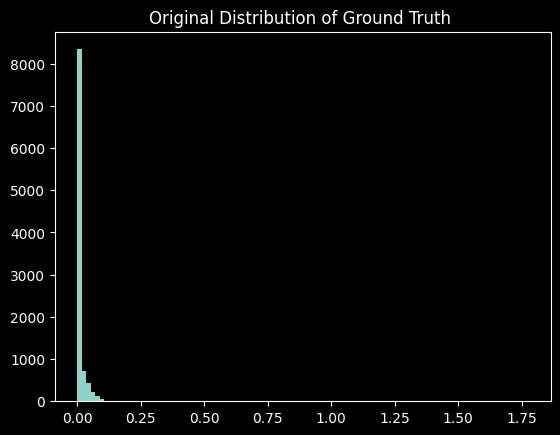

In [17]:
n = min(100, cw_np.shape[0])
c = cw_np[np.random.choice(range(cw_np.shape[0]), n, replace=False)]
p = 1 / np.exp(c)
print(p.mean(), p.std())
plt.hist(p.reshape(-1), bins=100)
plt.title("Original Distribution of Ground Truth ")

9.76709181798513 5.241097812597952


Text(0.5, 1.0, 'Distribution of Ground Truth Activated by 1/e^x')

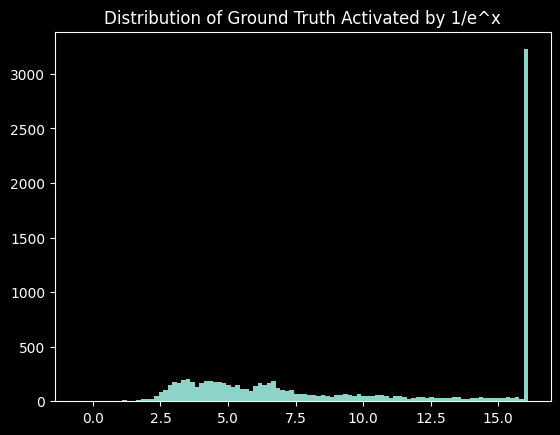

In [18]:
c = cw_np[np.random.choice(range(cw_np.shape[0]), n, replace=False)]
print(c.mean(), c.std())
plt.hist(c.reshape(-1), bins=100)
plt.title("Distribution of Ground Truth Activated by 1/e^x")

tensor(9.6947, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>) tensor(4.8104, device='cuda:0', dtype=torch.float64, grad_fn=<StdBackward0>)


Text(0.5, 1.0, 'Distribution of Generated Data')

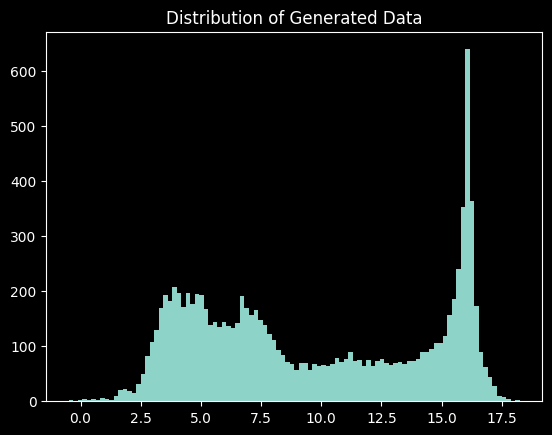

In [19]:
# print(model.mean, model.std)
z = torch.randn(n, Z_DIM).to(DEVICE, dtype=torch.float64).view(n, 1, Z_DIM)
h = model.decode(z)
print(h.mean(), h.std())
plt.hist(h.cpu().detach().numpy().reshape(-1), bins=100)
plt.title("Distribution of Generated Data")